# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [118]:
import os
import sys
import torch

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from data_loader import build_bitcoin_uts
from data_plotter import PlotFactory, PlotData
from ml_models import LinearRegressionModel, MLP, ModelFactory
from ts_models import RandomWalk, ARIMA_model, EvaluationMetric

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [119]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [120]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [121]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [122]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Plot Raw Data

- August 2017 to July 2023. The data has been meticulously collected from the Binance API, with price data captured at **one-minute intervals** [About Dataset](https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset)

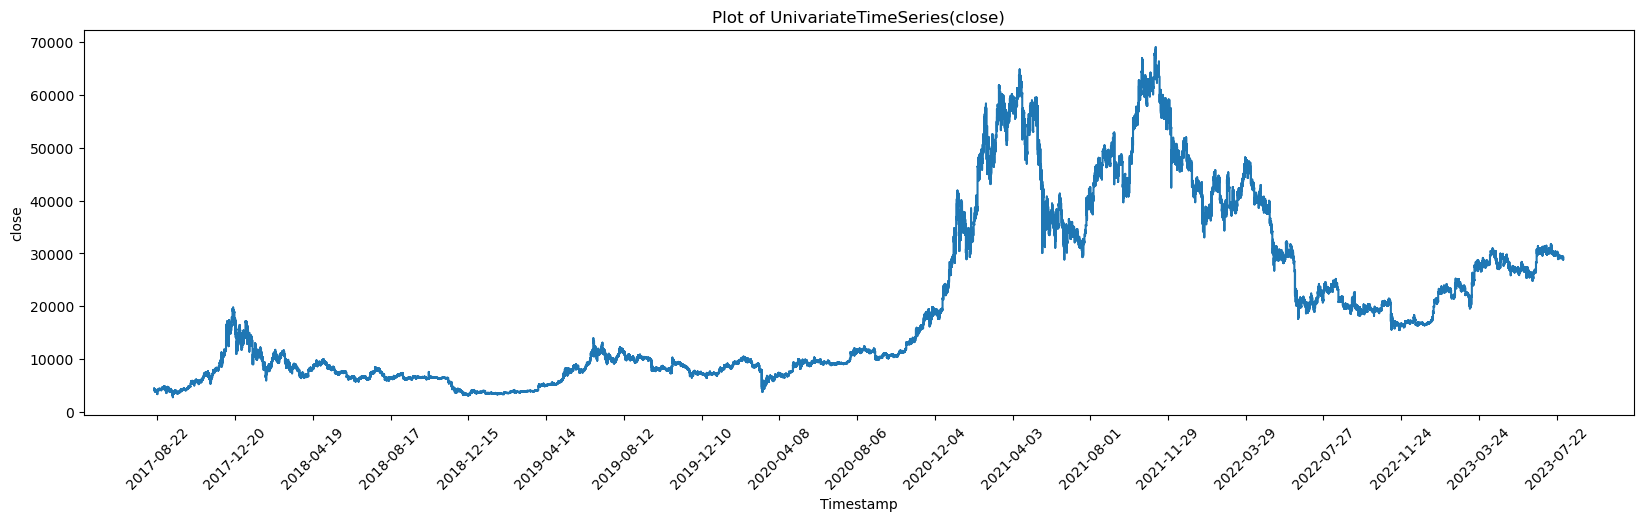

In [123]:
bitcoin_ts.plot(tick_skip=120)

### Get Descriptive Statistics of Raw Data

In [124]:
bitcoin_ts.get_statistics()

,close
count,3.126000e+06
mean,2.008946e+04
std,1.605896e+04
min,2.817000e+03
25%,7.624798e+03
50%,1.170000e+04
75%,2.989957e+04
max,6.900000e+04


In [125]:
bitcoin_ts.range_skewness_kurtosis()

{'Range': close    66183.0
 dtype: float64,
 'Skewness': close    1.029161
 dtype: float64,
 'Kurtosis': close   -0.056707
 dtype: float64}

### Check Stationarity of Raw Data

In [126]:
# both a taking a while
# bitcoin_ts.stationarity_test(bitcoin_df)

# from statsmodels.tsa.stattools import adfuller, bds

# adfuller(bitcoin_df)

- Stationarity test is taking a while. From looking at the graph, we can see that the time series is NOT stationary, so we can difference.

In [127]:
# bitcoin_series = bitcoin_ts.get_series()
# bitcoin_ts.independence_test(bitcoin_series)

- Independence test is taking a while as well. Assume that the data is dependent as there is correlation due to the time series being non-stationary.

### Initialize & Predict (RW) Model of Raw Data
- RW uses the raw data because the current observation depends on the previous, thus dependency is need and dependency is in raw data. Differencing removes this dependence.

In [128]:
bitcoin_series = bitcoin_ts.get_series()
bitcoin_series

array([ 4261.48,  4261.48,  4280.56, ..., 28902.49, 28902.49, 28902.49])

In [129]:
day_forecast = 60 * 24
# year_forecast = day_forecast * 365
forecasting_step = day_forecast
N = len(bitcoin_ts.get_series())
train_length = N - forecasting_step
train_length

3124560

In [130]:
train_uts, test_uts = bitcoin_ts.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 3124560


(UnivariateTimeSeries(UnivariateTimeSeries(close)[1:3124560]),
 UnivariateTimeSeries(UnivariateTimeSeries(close)[3124560:3126000]))

In [131]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(close)[1:3124560]
Timestamp,
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-07-31,29445.99
2023-07-31,29446.01
2023-07-31,29449.99


In [132]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(close)[3124560:3126000]
Timestamp,
2023-07-31,29453.99
2023-07-31,29438.00
2023-07-31,29439.99
2023-07-31,29440.00
2023-07-31,29439.99
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


In [133]:
# rw_model_class = RandomWalk()

# rw_predictions = rw_model_class.predict(train_df, test_df)

In [134]:
# type(rw_predictions[0]), len(rw_predictions), rw_predictions

In [135]:
# rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_predictions, per_element=False)
# rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_predictions, per_element=False)

- Both `MSE` and `RMSE` for the raw TS are high. Why?

In [136]:
# EvaluationMetric.plot_forecast(train_df, test_df, rw_predictions, per_element=False)
# # EvaluationMetric.plot_forecast_only(test_df, rw_predictions, per_element=True)
# # EvaluationMetric.plot_forecast_only(test_df, rw_predictions)

# EvaluationMetric.plot_predictions(test_df, rw_predictions)

### Initialize & Predict ARIMA Model of Raw Data
- ARIMA assumes non-stationarity

In [137]:
# lag_p = 1
# integrated_d = 1
# error_q = 1
# arima_model_class = ARIMA_model()
# arima_model = arima_model_class.train_arima_model(train_df, lag_p, integrated_d, error_q)

In [138]:
# # retrain false
# arima_predictions_no_retrain = arima_model_class.predict(arima_model, train_df, test_df, False, lag_p)

# # retrain true
# arima_predictions_retrain = arima_model_class.predict(arima_model, train_df, test_df, True, lag_p)

In [139]:
# arima_predictions_no_retrain

In [140]:
# arima_predictions_retrain

In [141]:
# len(test_df), len(arima_predictions_no_retrain), len(arima_predictions_retrain)

In [142]:
# arima_mse_no_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_no_retrain, per_element=False)
# arima_rmse_no_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_no_retrain, per_element=False)

# arima_mse_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
# arima_rmse_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

In [143]:
# EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_no_retrain, False)
# EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_retrain, False)
# EvaluationMetric.plot_predictions(test_df, arima_predictions_no_retrain)
# EvaluationMetric.plot_predictions(test_df, arima_predictions_retrain)

### MLP Model

- Reminder: Our data is in **one-minute intervals**.
- Predict every hour of the next day. 

In [144]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


#### Data Manipulation

In [145]:
# day_forecast = 60 * 24
# year_forecast = day_forecast * 365
# forecasting_step = year_forecast
previous_steps = 3
forecast_ahead = 3

X_train_mvts, y_train_mvts = reversed_bitcoin_ts.data_augment_to_mvts(previous_steps, forecast_ahead)
# type(X_train_mvts)

In [146]:
X_train_df = X_train_mvts.get_as_df()
X_train_df

,t-3,t-2,t-1
Timestamp,,,
2023-08-01,28902.49,28902.49,28902.49
2023-08-01,28902.49,28902.49,28908.53
2023-08-01,28902.49,28908.53,28907.41
2023-08-01,28908.53,28907.41,28895.99
2023-08-01,28907.41,28895.99,28890.39
...,...,...,...
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4261.48


In [147]:
y_train_df = y_train_mvts.get_as_df()
y_train_df

,t,t+1,t+2
Timestamp,,,
2023-08-01,28908.53,28907.41,28895.99
2023-08-01,28907.41,28895.99,28890.39
2023-08-01,28895.99,28890.39,28889.64
2023-08-01,28890.39,28889.64,28881.54
2023-08-01,28889.64,28881.54,28876.00
...,...,...,...
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4261.48
2017-08-17,4261.48,4261.48,4280.56


In [148]:
X_test_mvts, y_test_mvts = X_train_mvts.data_augment_to_test(y_train_mvts, previous_steps, forecast_ahead)

In [149]:
X_test_df = X_test_mvts.get_as_df()
X_test_df

,t-3,t-2,t-1
Timestamp,,,
2017-08-17,4261.48,4261.48,4280.56


In [150]:
y_test_df = y_test_mvts.get_as_df()
y_test_df

,t,t+1,t+2
Timestamp,,,
2017-08-17,4280.56,4261.48,4261.48


### Visualize Training and Testing Data plots

In [151]:
len(X_train_df), len(y_train_df), len(X_test_df), len(y_test_df)

(3125995, 3125995, 1, 1)

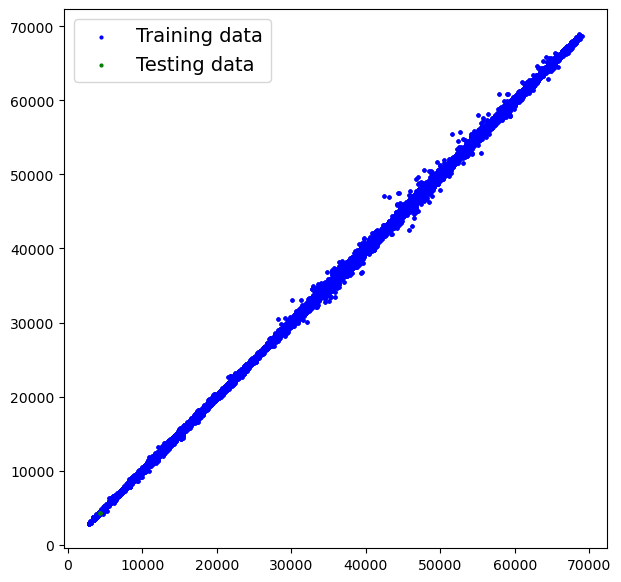

In-sample predictions or true predictions are not available.


In [152]:
interpolate_plotter = PlotFactory.create_plotter(
    plot_type='interpolate'
)

interpolate_plotter.plot_training_and_testing_data(X_train_df, y_train_df, X_test_df, y_test_df)

interpolate_plotter.plot()

In [153]:
# Create random seed because we initialize randomly and want to stablize our random values
# stablize as in keep random #s same; remove manual_seed() and model params will change
# helps with reproducing works
stabilizer = 42
torch.manual_seed(stabilizer)

In [154]:
linear_regression_model = LinearRegressionModel(stabilizer)
linear_regression_model, linear_regression_model.state_dict(), linear_regression_model.weights, linear_regression_model.bias

(LinearRegressionModel(),
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),
 Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True))

In [155]:
# Make predictions with model
with torch.inference_mode():
    pre_train_predictions = linear_regression_model.forward_pass(X_test_df.T)

pre_train_predictions

Timestamp,2017-08-17
t-3,1434.928071
t-2,1434.928071
t-1,1441.352124


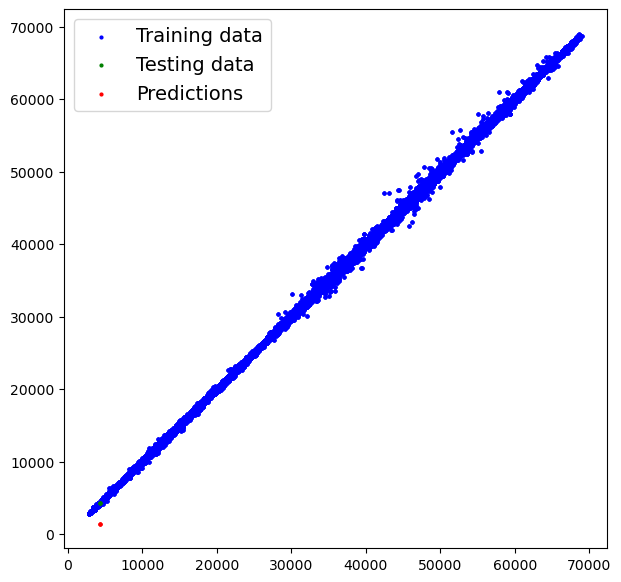

In-sample predictions or true predictions are not available.


In [156]:
interpolate_plotter_with_predictions = PlotFactory.create_plotter(plot_type='interpolate')
interpolate_plotter_with_predictions.plot_training_and_testing_data(X_train_df, y_train_df, X_test_df, y_test_df, pre_train_predictions)
interpolate_plotter_with_predictions.plot()

- Setup the SGD optimizer
- Stochastic [random] gradient descent [adjusts parameters]
- Communicates with the loss function by saying when I randomly adjust these parameters, do we tend in the direction we want?
    - if so, keep adjusting in this direction and 
    - if no, adjust in the other/another direction

In [157]:
# Setup a loss function - How wrong out model is
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=linear_regression_model.parameters(), lr=0.01) 
config = [loss_fn, optimizer]

In [158]:
# #times to loop through the training
# Hyperparameter
epochs = 2000

# Track different setups (ie: lr, etc) to compare this experiment to future experiments
epoch_count = []
train_pred_values = []
test_pred_values = []
train_loss_values = []
test_loss_values = []

### Training
# 0. Loop through the training
for epoch in range(epochs):
    
    train_y_preds, train_loss = linear_regression_model.train_model(X_train_df, y_train_df, config)
    test_y_preds, test_loss = linear_regression_model.interpolate_predictions(X_test_df, y_test_df, config)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")
        print(f"Parameters: {linear_regression_model.state_dict()}")
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

Epoch: 0 | Train loss: 13325.392578125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 10 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 20 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 30 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 40 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 50 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: OrderedDict([('weights', tensor([201.2315])), ('bias', tensor([0.1388]))])
Epoch: 60 | Train loss: 13325.4970703125 | Test loss: 854555.9375
Parameters: Ordere

In [159]:
train_loss_values

[tensor(13325.3926, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanBackward0>),
 tensor(13325.4971, grad_fn=<MeanB

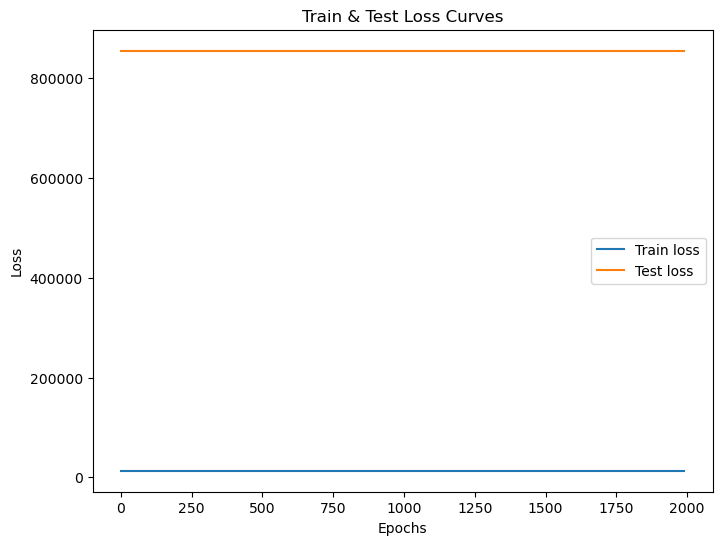

In [160]:
# train_loss_values_df = pd.DataFrame(np.array(torch.tensor(train_loss_values).numpy()))
# test_loss_values_df = pd.DataFrame(test_loss_values)

# Create plot data object
# plot_data = PlotData(epoch_count=epoch_count, train_loss_values_df=train_loss_values_df, test_loss_values_df=test_loss_values_df)

# # Create an instance of LossCurvePlotter using the Factory pattern
# loss_plotter = PlotFactory.create_plotter('loss_curve', **plot_data.__dict__)
# loss_plotter.plot()

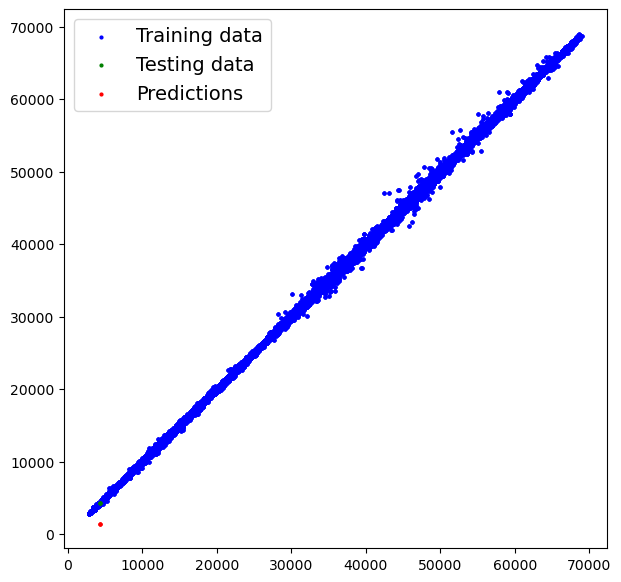

In-sample predictions or true predictions are not available.


In [161]:
# interpolate_plotter_with_predictions = PlotFactory.create_plotter(plot_type='interpolate')
# interpolate_plotter_with_predictions.plot_training_and_testing_data(X_train_df, y_train_df, X_test_df, y_test_df, test_y_preds)
# interpolate_plotter_with_predictions.plot()

In [170]:
hidden_size = 100
mlp_interpolate_model = MLP(previous_steps, hidden_size, forecast_ahead)
mlp_interpolate_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

In [171]:
mlp_interpolate_model, mlp_interpolate_model.state_dict()

(MLP(
   (fc1): Linear(in_features=3, out_features=100, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=100, out_features=3, bias=True)
 ),
 OrderedDict([('fc1.weight',
               tensor([[ 0.1823, -0.5016,  0.1573],
                       [-0.0470,  0.2637,  0.3313],
                       [-0.5740,  0.5295,  0.4842],
                       [ 0.2297, -0.5277, -0.2062],
                       [-0.1673, -0.1484,  0.3256],
                       [ 0.2099,  0.4574, -0.2162],
                       [ 0.1943,  0.2054, -0.4807],
                       [-0.5600, -0.2996,  0.3952],
                       [-0.5436, -0.5025,  0.3234],
                       [ 0.3115,  0.4748, -0.4359],
                       [-0.4226,  0.2962,  0.5021],
                       [ 0.3455,  0.0904,  0.1903],
                       [ 0.5480, -0.3725, -0.2621],
                       [ 0.4038, -0.3950, -0.3184],
                       [ 0.4215,  0.1822,  0.1865],
                       [-0.2447, -0.0080,

In [164]:
import torch

X_test_tensor = torch.tensor(X_test_df.values)
X_test_tensor

tensor([[4261.4800, 4261.4800, 4280.5600]], dtype=torch.float64)

In [167]:
# # Make predictions with model
# with torch.inference_mode():
#     pre_train_mlp_predictions = mlp_interpolate_model.forward_pass(X_test_tensor)

# pre_train_mlp_predictions

In [169]:
y_test_df

,t,t+1,t+2
Timestamp,,,
2017-08-17,4280.56,4261.48,4261.48


In [174]:
# #times to loop through the training
# Hyperparameter
epochs = 10

# Track different setups (ie: lr, etc) to compare this experiment to future experiments
epoch_count = []
mlp_train_pred_values = []
mlp_test_pred_values = []
mlp_train_loss_values = []
mlp_test_loss_values = []

### Training
# 0. Loop through the training
for epoch in range(epochs):
    
    mlp_train_y_preds, mlp_train_loss = mlp_interpolate_model.train_model(X_train_df, y_train_df, config)
    mlp_test_y_preds, mlp_test_loss = mlp_interpolate_model.interpolate_predictions(X_test_df, y_test_df, config)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        print(f"Epoch: {epoch} | Train loss: {mlp_train_loss} | Test loss: {mlp_test_loss}")
        print(f"Parameters: {mlp_interpolate_model.state_dict()}")
        mlp_train_loss_values.append(mlp_train_loss)
        mlp_test_loss_values.append(mlp_test_loss)

Epoch: 0 | Train loss: 19097.134765625 | Test loss: 4056.370849609375
Parameters: OrderedDict([('fc1.weight', tensor([[ 0.1823, -0.5016,  0.1573],
        [-0.0470,  0.2637,  0.3313],
        [-0.5740,  0.5295,  0.4842],
        [ 0.2297, -0.5277, -0.2062],
        [-0.1673, -0.1484,  0.3256],
        [ 0.2099,  0.4574, -0.2162],
        [ 0.1943,  0.2054, -0.4807],
        [-0.5600, -0.2996,  0.3952],
        [-0.5436, -0.5025,  0.3234],
        [ 0.3115,  0.4748, -0.4359],
        [-0.4226,  0.2962,  0.5021],
        [ 0.3455,  0.0904,  0.1903],
        [ 0.5480, -0.3725, -0.2621],
        [ 0.4038, -0.3950, -0.3184],
        [ 0.4215,  0.1822,  0.1865],
        [-0.2447, -0.0080,  0.5284],
        [-0.3465,  0.0045,  0.2746],
        [-0.3986,  0.5607, -0.2885],
        [-0.1386, -0.1562, -0.3762],
        [-0.5665,  0.3255,  0.1534],
        [-0.5407, -0.3716,  0.5706],
        [ 0.2207,  0.2317, -0.3454],
        [-0.2531, -0.0872, -0.1056],
        [-0.3956,  0.0476,  0.0574],
  

In [176]:
mlp_train_loss_values

[tensor(19097.1348, grad_fn=<MeanBackward0>)]

### Follow-up
- What can we determine from this?
    - Raw TS
        - `RW`
        - `ARIMA-no-retrain`
        - `ARIMA-retrain`
        - `MLP`: Loss not decreasing rapidly after 250.